In [1]:
import os
import requests
from typing import Annotated, Literal , List
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel, Field , field_validator, ValidationInfo
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt
from langgraph.graph.message import AnyMessage
from API.booking import BookingAPI
from API.geoCoding import GeoCodingAPI
from API.getKey import OAuthClient
from API.getQuotes import QuotesAPI
from API.is_Airport import IsAirport

from langgraph.graph import StateGraph, MessagesState, START, END


In [2]:
memory = MemorySaver()

members = ["bookingCar", "chatNormal"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]
# router_model = raw_model.with_structured_output(Router)


llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")
jupiterAPI = os.getenv('JUPITER_API')
quoteAPI = str(jupiterAPI) + "/demand/v1/quotes"
bookingsAPI  = str(jupiterAPI) + '/demand/v1/bookings'

In [3]:
class BookingCarDetails(BaseModel):
    """Details for the bookings car details"""
    name: str = Field(
        ...,
        description="The name of the person booking the ride.This is optional if provided",
    )
    number_phone: str = Field(
        ...,
        description="The phone number of the user.This is optional if provided",
    )
    pick_up_location: str = Field(
        ...,
        description="The location where the user will be picked up. This can be a full address or a specific location name.This is optional if provided",
    )
    destination_location: str = Field(
        ...,
        description="The destination location for the ride. This can be a full address or a specific location name.This is optional if provided"
    )
    pick_up_time: str = Field(
        ...,
        description="The time the user intends to be picked up. No format keeps the text related to time..This is optional if provided"
    )
    @field_validator('pick_up_location')
    @classmethod
    def validate_pickup(cls, value:str):
        geoCodingAPI = GeoCodingAPI()
        geoCoding_pickup = geoCodingAPI.get_geocoding(value)
        if geoCoding_pickup["status"] == "OK" :
            return geoCoding_pickup['results'][0]['formatted_address']
        else:
            raise ValueError(f"Invalid pick-up location: {value}")
    @field_validator('destination_location')
    @classmethod
    def validate_destination(cls, value : str, info: ValidationInfo):
        geoCodingAPI = GeoCodingAPI()
        geoCoding_destination = geoCodingAPI.get_geocoding(value)
        print (geoCoding_destination['results'][0]['formatted_address'])
        if geoCoding_destination["status"] == "OK":
            if geoCoding_destination['results'][0]['formatted_address'] == info.data['pick_up_location']:
                raise ValueError(f"Invalid destination location: {value}")
            else:
                return {geoCoding_destination['results'][0]['formatted_address']}
        else:
           
            raise ValueError(f"Invalid destination location: {value}")

class State(MessagesState):
    next: str

In [4]:
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

In [5]:
def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

In [6]:
state_sample = {
    "messages": [
        {"role": "user", "content": "hi"}
    ]
}

In [7]:
supervisor_node(state_sample)

Command(update={'next': 'chatNormal'}, goto='chatNormal')

In [8]:
import os
import requests
from typing import Annotated, Literal , List
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel, Field , field_validator, ValidationInfo
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt
from langgraph.graph.message import AnyMessage
from API.booking import BookingAPI
from API.geoCoding import GeoCodingAPI
from API.getKey import OAuthClient
from API.getQuotes import QuotesAPI
from API.is_Airport import IsAirport

from langgraph.graph import StateGraph, MessagesState, START, END

    # quote_id: str
    # booking_info: BookingCarDetails
    
def check_what_is_empty(user_personal_details):
    ask_for = []
    # Check if fields are empty
    for field, value in user_personal_details.model_dump().items():
        if value in [None, "", 0]:  # Add other 'empty' conditions if needed
            print(f"Field '{field}' is empty.")
            ask_for.append(field)
    return ask_for


def add_non_empty_details(current_details: BookingCarDetails, new_details: BookingCarDetails):
    non_empty_details = {k: v for k, v in new_details.model_dump().items() if v not in [None, ""]}
    updated_details = current_details.model_copy(update=non_empty_details)
    return updated_details
def update_details(current_details: BookingCarDetails, new_details: BookingCarDetails , field : str):
    # non_empty_details = {k: v for k, v in new_details.model_dump().items() if v not in [None, ""]}
    updated_details = current_details.model_copy(update=field)
    return updated_details

def ask_for_info(ask_list: list):
    first_prompt = ChatPromptTemplate.from_template(
        """Ask one question at a time, even if you don't get all the info. Don't list the questions or greet the user. 
        Explain you're gathering info to help. If 'ask_for' is empty, thank the user and ask how you can assist next.
        ### ask_for list: {ask_for}"""
    )

    info_gathering_chain = first_prompt | llm | StrOutputParser()
    ai_chat = info_gathering_chain.invoke({"ask_for": ask_list})
    print(first_prompt)
    return ai_chat
def filter_response(text_input, user_details : BookingCarDetails ):
    chain = llm.with_structured_output(BookingCarDetails)
    res = chain.invoke(text_input)
    # add filtered info to the
    user_details = add_non_empty_details(user_details,res)
    ask_for = check_what_is_empty(user_details)
    return user_details, ask_for
def ask_confirm_info(booking_details: BookingCarDetails):
    # booking_details.
    message = (
        f"Please confirm your ride details:\n"
        f"- Pickup Location: {booking_details.pick_up_location}\n"
        f"- Destination: {booking_details.destination_location}\n"
        f"- Pickup Time: {booking_details.pick_up_time}\n"
        f"- Name: {booking_details.name}\n"
        f"- Contact Number: {booking_details.number_phone}\n"
    )
    print(message)

@tool
def get_booking_details(state : State):
    """ Call function to get the details for a booking from user"""
    chain = llm.with_structured_output(BookingCarDetails)
    print(state["messages"])
    response =chain.invoke(state["messages"][-1])
    booking_details = BookingCarDetails(
        name="", number_phone="", pick_up_location="", destination_location="", pick_up_time=""
    )
    user_details = add_non_empty_details(booking_details, response)
    ask_for = check_what_is_empty(user_details)
    while ask_for:  
        ai_response = ask_for_info(ask_for)
        print(ai_response)
        text_input = input()
        user_details, ask_for = filter_response(text_input, user_details)
    return user_details
@tool
def get_quotes(booking_details : BookingCarDetails):
    """Call function to fetches quotes for car bookings based on the provided booking details."""
    quotesAPI = QuotesAPI(os.getenv("JUPITER_API") + "/demand/v1/quotes")
    geoCodingAPI = GeoCodingAPI()
    print("GeoCoding API")
    # geoCoding_destination =
    geoCoding_pickup =  geoCodingAPI.get_geocoding(booking_details.pick_up_location)
    geoCoding_destination = geoCodingAPI.get_geocoding(booking_details.destination_location)
    
    # input_datetime = datetime.fromisoformat(pick_up_time)
    pickup_datetime = "2025-01-20T09:24:10.000Z"
    
    pickup_coords = { "latitude": float(geoCoding_pickup['results'][0]['geometry']['location']['lat']),"longitude": float(geoCoding_pickup['results'][0]['geometry']['location']['lng']),}
    destination_coords = { "latitude": float(geoCoding_destination['results'][0]['geometry']['location']['lat']),"longitude": float(geoCoding_destination['results'][0]['geometry']['location']['lng']),}
    quotes_data = quotesAPI.get_quotes(pickup_datetime, pickup_coords, destination_coords)
    return quotes_data
@tool
def ask_confirm(booking_details : BookingCarDetails):
    """Ask the user again to confirm the booking details. """
    message = (
        f"Please confirm your ride details:\n"
        f"- Pickup Location: {booking_details.pick_up_location}\n"
        f"- Destination: {booking_details.destination_location}\n"
        f"- Pickup Time: {booking_details.pick_up_time}\n"
        f"- Name: {booking_details.name}\n"
        f"- Contact Number: {booking_details.number_phone}\n"
    )
    print(message)
    user_input = input()
    return "User confirm " + user_input
@tool
def change_info(fields : List[str], booking_details : BookingCarDetails):
    """Change the booking details field """
    for field in fields:
        ai_response = ask_for_info([field])
        print(ai_response)
        text_input = input()
        chain = llm.with_structured_output(BookingCarDetails)
        response =chain.invoke(text_input)
        user_details = add_non_empty_details( user_details,response)
    return user_details 

In [17]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent
system_prompt = """
        You are a very powerful assistant. Be polite, clear, and understandable.
        If users ask general questions, answer them helpfully. If users want to book a ride, 
        call the 'get_booking_details' function to gather booking information.
        If you have full booking information, ask the user to confirm the booking.
        If the user confirms, call the 'get_quotes' function to retrieve quotes. 
        if the user not confirmed ,please ask user what the field want change Do not attempt to wildly guess then call the 'change_info'
        Thanks for user when complete booking
    """
tool_booking = [get_booking_details, ask_confirm, get_quotes , change_info]  
booking_agent = create_react_agent(
    llm, tools=tool_booking , state_modifier=system_prompt
)


def booking_node(state: State) -> Command[Literal["supervisor"]]:
    result = booking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="bookingCar")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chat_agent = create_react_agent(llm, tools = [])


def chat_node(state: State) -> Command[Literal["supervisor"]]:
    result = chat_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="chatNormal")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("bookingCar", booking_node)
builder.add_node("chatNormal", chat_node)
graph = builder.compile()

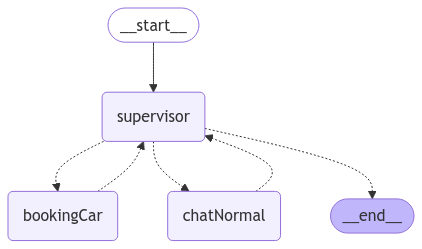

In [10]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
for s in graph.stream(
    {"messages": [("user", "hi")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'chatNormal'}})
----
(('chatNormal:b0fb114a-6927-4ab3-dab2-f2de1bc7bb2f',), {'agent': {'messages': [AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-d1c22b45-d73a-4ab7-aa3b-1eeec734a21c-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}})
----
((), {'chatNormal': {'messages': [HumanMessage(content='Hello! How can I assist you today?', additional_kw

In [18]:
for s in graph.stream(
    {"messages": [("user", "i want to book a car ")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'bookingCar'}})
----
(('bookingCar:237abbaf-7d8b-6c15-ce88-a05a1c269bc8',), {'agent': {'messages': [AIMessage(content="I can help you with that! Let's start by gathering some details for your booking. \n\nPlease provide the following information:\n\n1. Your name (optional)\n2. Your phone number (optional)\n3. The pick-up location\n4. The destination location\n5. The time you intend to be picked up\n\nOnce I have this information, I can proceed with your booking.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 78, 'prompt_tokens': 3643, 'total_tokens': 3721, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-5e5a5bef-48d0-4bf9-806f

KeyboardInterrupt: 